In [7]:
################################
###  Read Passwords Dataset  ###
################################
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/Shareddrives/ENLP Final Projects - Passwords/autoencoder/"

passwords = pd.read_csv(path + "data/15000passwords.csv", dtype={'Numeric': str})
print(passwords)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       Unnamed: 0           Passwords
0               0        Aabacus3417!
1               1    Babdomen2849410@
2               2     Cabdominal1889$
3               3         Dabide0758%
4               4       Eabiding7988*
...           ...                 ...
15535       15535        Nzero664790@
15536       15536    Ozestfully42710$
15537       15537        Pzesty31810%
15538       15538  Qzigzagged2932108*
15539       15539       Rzipfile4701_

[15540 rows x 2 columns]


In [8]:
##################################
###  Pad & Tokenize Passwords  ###
##################################
from keras.utils import to_categorical
from keras.preprocessing import sequence

# Identify max password length in dataset and pad rest of the passwords such that all of them have the same length.
# Haveing same length sequences is a requirement for LSTM
PAD_CHAR = "~"
PASS_LENGTH = max([len(p) for p in passwords["Passwords"]])

padded_passwords = []
charset = set(PAD_CHAR)               # start with the initial padding char
for p in passwords["Passwords"]:
  padded_passwords.append(p.ljust(PASS_LENGTH, PAD_CHAR))
  charset |= set(p)                   # |= is the union set operation.

# Convert characters to integers 
vocab_size = len(charset)
char2id = dict((c, i) for i, c in enumerate(charset))

# One hot encode the passwords
encoded_passwords = [[char2id[c] for c in password] for password in padded_passwords]
one_hot_encoded = np.array([to_categorical(p, num_classes=vocab_size) for p in encoded_passwords])

print(PASS_LENGTH)
print(vocab_size)
print(np.shape(encoded_passwords))

22
71
(15540, 22)


# Variational Autoencoders

In [9]:
##########################
###  Create VAE Model  ###
##########################
from keras import objectives
from keras import backend as K
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Lambda, Layer, Bidirectional
from keras.models import Model
import tensorflow as tf

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


def create_lstm_vae(timesteps, layer_sizes, vocab_size, epsilon_std=1.,
                    batch_size=10):
  """
  """
  def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(layer_sizes[-1],),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(.5 * z_log_sigma) * epsilon
  
  # Create encoder model
  enc_input = Input(batch_shape=(batch_size, timesteps, vocab_size))
  x = enc_input
  for idx, layer_size in enumerate(layer_sizes):
    ret_seq = (idx != len(layer_sizes) - 1) # False for the last layer_size
    x = Bidirectional(LSTM(layer_size, return_sequences=ret_seq))(x)
  enc_output = Dense(layer_sizes[-1], activation="relu")(x)
  z_mean = Dense(layer_sizes[-1])(enc_output)
  z_log_sigma = Dense(layer_sizes[-1])(enc_output)
  z = Lambda(sampling, output_shape=(layer_sizes[-1],))([z_mean, z_log_sigma])
  encoder = Model(enc_input, z_mean, name="Encoder")

  # Create decoder model
  bottleneck_size = layer_sizes[-1]
  dec_input = Input((bottleneck_size,))
  layer = RepeatVector(timesteps)
  x = layer(z)
  _x = layer(dec_input)
  for layer_size in layer_sizes[::-1][1:]:
    layer = Bidirectional(LSTM(layer_size, return_sequences=True))
    x = layer(x)
    _x = layer(_x)
  layer =  TimeDistributed(Dense(vocab_size, activation="softmax"))
  dec_output = layer(x)
  _dec_output = layer(_x)
  decoder = Model(dec_input, _dec_output, name="Decoder")

  # connected_decoder = decoder(z_mean)

  # Create autoencoder model
  autoencoder = Model(enc_input, dec_output, name="Autoencoder")
  # autoencoder = Model(enc_input, connected_decoder, name="Autoencoder")

  # Variational autoencoder custom loss categorical entropy loss + KL loss
  def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.categorical_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    xent_loss = K.sum(xent_loss, axis=-1)
    return xent_loss + kl_loss

  autoencoder.compile(loss=vae_loss, optimizer="adam", metrics=['categorical_accuracy'], experimental_run_tf_function=False)
  return encoder, decoder, autoencoder

In [10]:
variational_encoder, variational_decoder, variational_autoencoder = create_lstm_vae(PASS_LENGTH, [16, 10, 6], vocab_size)
variational_encoder.summary()
variational_decoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(10, 22, 71)]            0         
_________________________________________________________________
bidirectional_5 (Bidirection (10, 22, 32)              11264     
_________________________________________________________________
bidirectional_6 (Bidirection (10, 22, 20)              3440      
_________________________________________________________________
bidirectional_7 (Bidirection (10, 12)                  1296      
_________________________________________________________________
dense_4 (Dense)              (10, 6)                   78        
_________________________________________________________________
dense_5 (Dense)              (10, 6)                   42        
Total params: 16,120
Trainable params: 16,120
Non-trainable params: 0
_______________________________________________________

In [11]:
variational_autoencoder.fit(one_hot_encoded, one_hot_encoded, epochs=200, batch_size=10)

Train on 15540 samples
Epoch 1/200
15540/15540 [==============================] - 241s 15ms/sample - loss: 49.5768 - categorical_accuracy: 0.4006
Epoch 2/200
15540/15540 [==============================] - 234s 15ms/sample - loss: 41.7288 - categorical_accuracy: 0.4303
Epoch 3/200
15540/15540 [==============================] - 234s 15ms/sample - loss: 40.6454 - categorical_accuracy: 0.4342
Epoch 4/200
15540/15540 [==============================] - 233s 15ms/sample - loss: 40.0937 - categorical_accuracy: 0.4356
Epoch 5/200
15540/15540 [==============================] - 230s 15ms/sample - loss: 39.8015 - categorical_accuracy: 0.4357
Epoch 6/200
15540/15540 [==============================] - 230s 15ms/sample - loss: 39.5886 - categorical_accuracy: 0.4362
Epoch 7/200
15540/15540 [==============================] - 232s 15ms/sample - loss: 39.5213 - categorical_accuracy: 0.4362
Epoch 8/200
 4560/15540 [=======>......................] - ETA: 2:42 - loss: 39.5656 - categorical_accuracy: 0.4361

KeyboardInterrupt: ignored

In [ ]:
# Recosntruct passwords through autoencoder as vectors
reconst_passwd_vecs = variational_autoencoder.predict(one_hot_encoded, batch_size=10)
# Reverse one hot encoding to covnert passwords to strings
unpad = lambda text: text.replace(PAD_CHAR, "")
one_hot_decode = lambda one_hot_vectors: "".join([list(charset)[np.argmax(vec)] for vec in one_hot_vectors])
reconst_passwd_str = [unpad(one_hot_decode(p)) for p in reconst_passwd_vecs]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
# Compare original vs reconstructed passwords
passwords_df = pd.DataFrame(zip(passwords["FullPassword"], reconst_passwd_str),
                            columns = ['Original Password', 'Recosntructed Password'])
passwords_df.head(10)

,Original Password,Recosntructed Password
0,Acafe2019!,Acafe2019!
1,Ahyper2019!,Ahyper2019!
2,Pleet10!,Aleet10!
3,Ababe2!,Ababe1!
4,Tbingo1234*,Abingo1234!
5,Eleet2019@,Aleet2019!
6,Tninja123!,Aninja1234
7,Aninja777*,Aninja123*
8,Ababe101*,Ababe111!
9,Tbingo2019_,Abingo2019!


In [ ]:
################################
###  Generate New Passwords  ###
################################
import random

# Feel free to change the latent space values as you like and explore what comes
# out from the decoder
mu, sigma = 0, 3
new_passwords = []
for i in range(100):
  latent_sample = np.array([np.random.normal(mu, sigma, 6)])
  new_password_vec = variational_decoder.predict(latent_sample)
  new_password_str = unpad(one_hot_decode(new_password_vec[0]))
  new_passwords.append(new_password_str)
new_passwords_df = pd.DataFrame(new_passwords, columns=["Password"])

# Save them into a CSV file
new_passwords_df.to_csv(path + 'data/output/vae_sample_pass.csv', sep=',')

new_passwords_df.head(10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


,Password
0,Ababe2!
1,Tleet2!
2,AAyceemannn27
3,Aleet0019!
4,Ahabe2!
5,Abingg201!
6,Abingo1219!
7,Ahackerm1n2019!
8,Abigo1
9,Abingo111!


In [ ]:
#######################################
###  Calcualte the Average Entropy  ###
#######################################
!pip install BiEntropy

from bientropy import bien, tbien

sum_entropy = 0
max_entropy = float('-inf')
min_entropy = float('inf')

for pswd in new_passwords:
  pswd_bytes = bytes(pswd, 'utf-8')
  e = tbien(pswd_bytes)
  sum_entropy += e
  # update the max and the min entropy
  max_entropy = max(max_entropy, e)
  min_entropy = min(min_entropy, e)

avg_entropy = sum_entropy / len(new_passwords)

print("MAX entropy: " + str(max_entropy))
print("MIN entropy: " + str(min_entropy))
print("AVG entropy: " + str(avg_entropy))

MAX entropy: 0.9720206778899985
MIN entropy: 0.04472879972300151
AVG entropy: 0.9135753011113651


  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=27c6845c53af4df6492f9c8a8fcdeb090441d1438dcb3f74ff97925426e9653f
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Plotting t-SNE visualization...


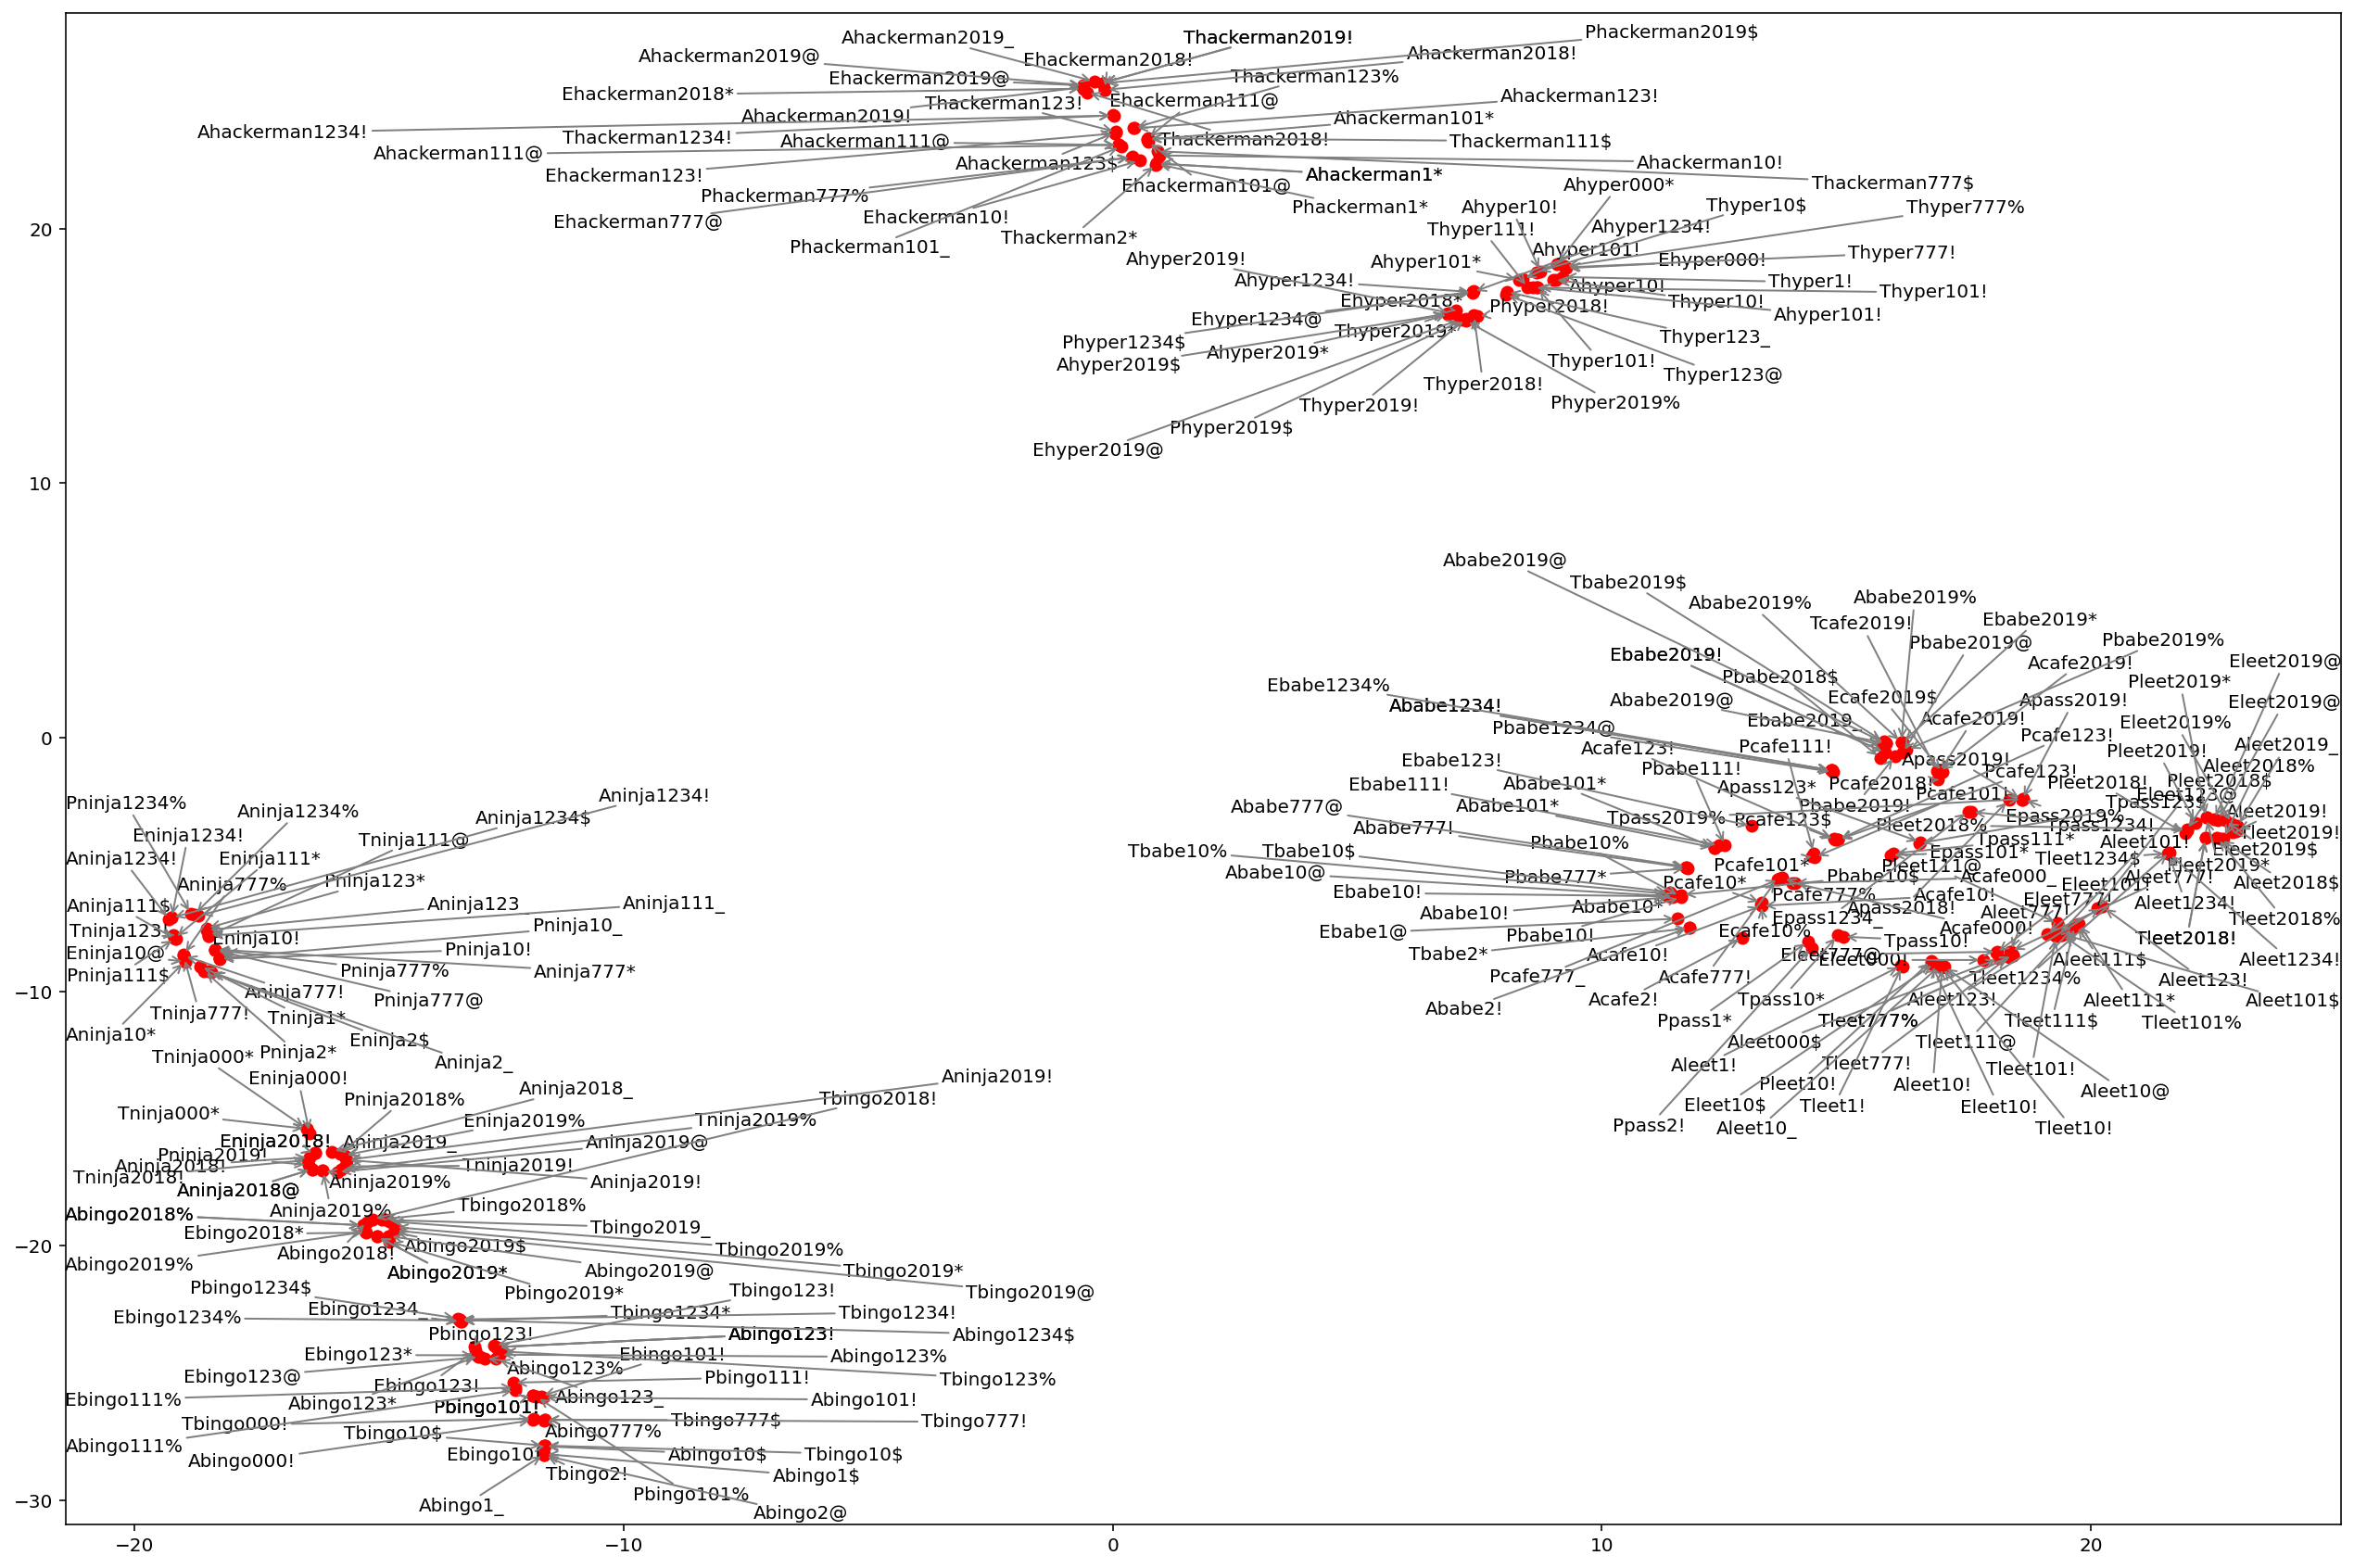

In [ ]:
#############################################
###  Visualize Passowrds in Latent Space  ###
#############################################
!pip install adjustText

%config InlineBackend.figure_format = 'retina'

from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox
from sklearn import manifold

def t_sne(latent_passwords, original_passwords, plot=True):
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(latent_passwords)
    if plot:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(22,15))
        plt.plot(X_tsne[:, 0], X_tsne[:, 1], 'ro')
        texts = [plt.text(X_tsne[:, 0][i], X_tsne[:, 1][i], '%s' %original_passwords[i], ha='center', va='center') for i in range(len(original_passwords))]
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
        plt.show()
    else:
        return X_tsne, tsne

limit = 300
latent_passwords = variational_encoder.predict(one_hot_encoded[:limit], batch_size=10)
t_sne(latent_passwords, passwords["FullPassword"][:limit])